Group 2 Members: Marcos Conde, Jose Manuel Lopez Camuñas, Alex Martin Martinez

In [1]:
!pip install tqdm

In [2]:
import cv2
import numpy as np
import pickle
import os
import warnings
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

num_cores = multiprocessing.cpu_count()

warnings.filterwarnings('ignore')

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]

train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

# Bag of words with Dense SIFT

First it will be tested the optimal scale to be used with the dense SIFT. The number of keypoints used will be 5000 and we will reduce cardinality with lda as in the previous week we found that the best results were achieved when this number of keypoints were used. 

In [4]:
def evaluate_lda(visual_words_train, visual_words_test,n_components=7,n_neighbors=5,metric='euclidean', cross_val = True):
    # Regular Implementation
    if not cross_val:
        # Reduce Data Cardinality
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(visual_words_train,train_labels)
        # KNN with reduced Data
        knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnlda.fit(VWlda, train_labels) 
        # Reduce test
        vwtestlda = lda.transform(visual_words_test)
        # Evaluate test
        accuracy = 100*knnlda.score(vwtestlda, test_labels)
        return accuracy
    

    # StratifiedKFold Implementation
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = []
    
    def accuracy_cal(train_index, test_index):
        # K Fold
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]   
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))

        # Reduce Data Cardinality
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(X_train ,y_train)
        # KNN with reduced Data
        knnlda = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnlda.fit(VWlda, y_train)
        # Reduce test
        vwtestlda = lda.transform(X_test)
        # Evaluate test
        accuracy.append(100*knnlda.score(vwtestlda, y_test))
        
    
    # Multithread Approach
    Parallel(n_jobs=num_cores,backend='threading')(delayed(accuracy_cal)(train_index, test_index)for train_index, test_index in tqdm(kf.split(visual_words_train, train_labels),position=0, leave=True))
        
        
    # Final Score
    return sum(accuracy)/len(accuracy)

 Then we turn those descriptors into visual words

In [5]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

def get_visual_words(descriptors,descriptors_np,codebook,k,test=False):
    # Fit codebook for training
    if not test:
        codebook.fit(descriptors_np)
        
    visual_words = np.zeros((len(descriptors), k), dtype=np.float32)
    def get_words_and_visual(i):
        
        words = codebook.predict(descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength=k)
        return words
    
    # Get words/visual words
    words = Parallel(n_jobs=num_cores,backend='threading')(delayed(get_words_and_visual)(i) for i in tqdm(range(len(descriptors)),total=len(descriptors), position=0, leave=True))
        
    
    return words, visual_words

In [6]:
def get_dense_SIFT_features(images, lbls, nfeatures=5000,scaling=1):
    descriptors = []
    label_per_descriptor = []
    descriptors_np = None

    # SIFT extractor
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    
    def descriptors_and_labels(filename, label):
        # Read image, cast to gray and resize by scaling
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)

        # Extract Keypoints and compute descriptors
        step_size = 5
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]

        kp, des = sift.compute(gray, kp)

        # Save descriptor and labels
        descriptors.append(des)
        label_per_descriptor.append(label)
        
        
    
    Parallel(n_jobs=num_cores,backend='threading')(delayed(descriptors_and_labels)(filename,label)for filename, label in tqdm(zip(images,lbls),total = len(images), position=0, leave=True))
        
    
    descriptors_np = np.vstack(descriptors)

    
    return descriptors_np, descriptors, label_per_descriptor

### Plotting Some Data

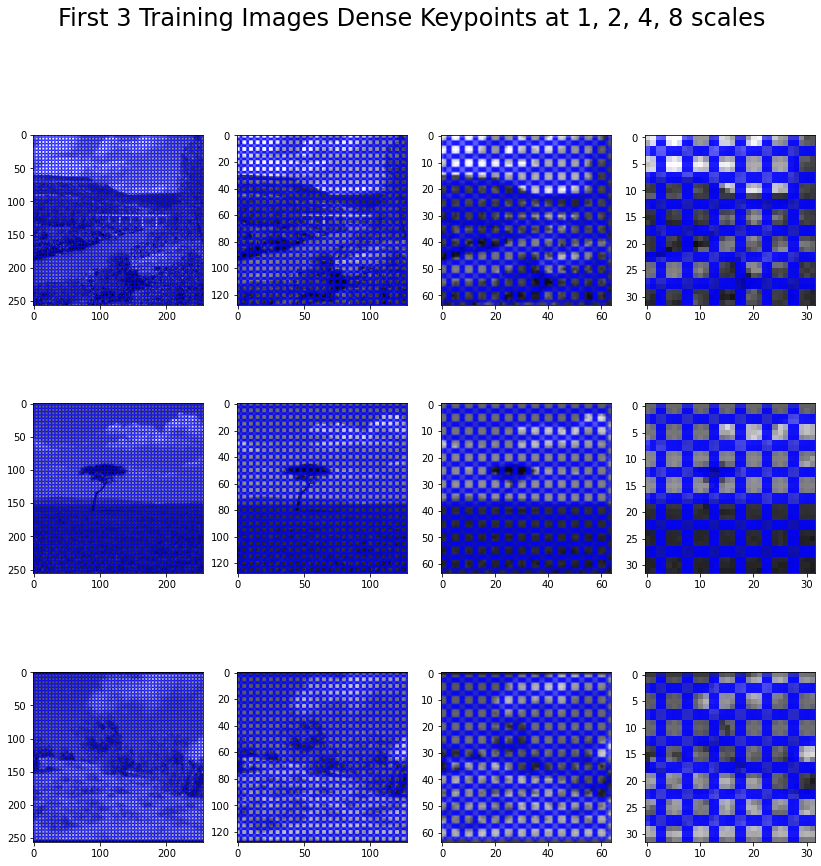

In [7]:

import matplotlib.pyplot as plt

def get_image_kp(filename,scaling):
    # Read image, cast to gray and resize by scaling
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)

    # Extract Keypoints and draw them on the image
    step_size = 5
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                    for x in range(0, gray.shape[1], step_size)]
    im_with_keypoints = cv2.drawKeypoints(gray,kp,np.array([]),(0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return im_with_keypoints



fig = plt.figure(figsize=(14, 14))
columns = 4
rows = 3

# Plot first 3 training images with keypoints on at different scales 
for idx, filename in enumerate(train_images_filenames[:3]):
    im1 = get_image_kp(filename, 1)
    fig.add_subplot(rows, columns, 1 + idx*columns)
    plt.imshow(im1)

    im2 = get_image_kp(filename, 2)
    fig.add_subplot(rows, columns, 2 + idx*columns)
    plt.imshow(im2)

    im4 = get_image_kp(filename, 4)
    fig.add_subplot(rows, columns, 3 + idx*columns)
    plt.imshow(im4)

    im8 = get_image_kp(filename, 8)
    fig.add_subplot(rows, columns, 4 + idx*columns)
    plt.imshow(im8)

fig.suptitle('First 3 Training Images Dense Keypoints at 1, 2, 4, 8 scales', fontsize=24)
plt.show()

# Evaluating Dense SIFT at different scales

In [8]:
def evaluate_dense_SIFT(nfeatures=5000,scaling=1, k=128):
    print("Evaluating Dense SIFT with {} features and scaling {}".format(nfeatures,scaling))
    print(50*"-")

    # Path to store precalculated data
    if not os.path.exists("./stored_results"):
        os.mkdir("./stored_results")
    
    # File to save/search
    f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}.pkl".format(scaling,nfeatures,k)

    # If its not already saved we compute
    if f not in os.listdir("./stored_results"):
        # Get Dense SIFT Descriptors
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)

        # Compute Visual Words
        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        # Save Visual Words
        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    # We load precalculated data
    else:
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

    # Evaluate with CV
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

In [9]:
scales = [1,2,4,8]

results = {}

for n in scales: 
    results[str(n)+" scaling"] = evaluate_dense_SIFT(nfeatures=5000,scaling=n)

5it [00:00, 2516.99it/s]

Evaluating Dense SIFT with 5000 features and scaling 1
--------------------------------------------------



5it [00:00, 1998.43it/s]

Evaluating Dense SIFT with 5000 features and scaling 2
--------------------------------------------------



5it [00:00, 1205.61it/s]

Evaluating Dense SIFT with 5000 features and scaling 4
--------------------------------------------------



5it [00:00, 3311.47it/s]

Evaluating Dense SIFT with 5000 features and scaling 8
--------------------------------------------------


#### DataFrame format (Numerical Representation)

In [10]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
1 scaling,78.008870
2 scaling,71.467367
4 scaling,61.088635
8 scaling,46.196826


#### Ploting Results

We can observe that as the images get smaller the accuracy of the method also decreases. It may be caused by the fact that the images loses resolutions and therefore information.

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Evaluating Dense SIFT at different scales and number of keypoints
We will also look if varying the number of features in the downsacaled images can produce better results. We will test it with images being reduced 4 times it's original size

In [ ]:
opt = [100,1000,5000, 10000,50000]

results = {}

for n in opt:   
    results[str(n)+" features"] = evaluate_dense_SIFT(nfeatures=n,scaling=4)

#### DataFrame format (Numerical Representation)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

#### Ploting Results

The number of features used when the image has been downscaled seems to have small(close to no effect) in the performance once the image has been downscaled. (Probably because of the DENSE SIFT)

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Testing different codebook k sizes for the dense SIFT

Using the previous scaling found to be the best one we will also test the best k for the previous seleceted parameters

In [ ]:
def evaluate_k_codebook(k_values:list(),nfeatures=5000):
    

    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels)
    
    results = {}
    
    for k in k_values:
        print("Evaluating SIFT with {} features and k={}".format(nfeatures,k))
        print(50*"-")
        f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}.pkl".format(1,nfeatures,k)
        if f not in os.listdir("./stored_results"):
            # Compute Visual Words
            codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
            words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
            words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)
            # Save Visual Words
            pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
            pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    
        else:
            # Load Precalculated Visual Words
            visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
            visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

        results["k = "+str(k)]= evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
        
    return results
    


opt = [32, 64, 128, 256, 512, 1024]

results = evaluate_k_codebook(nfeatures=2500, k_values=opt)

#### DataFrame format (Numerical Representation)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

#### Ploting Results
When varying the codebook sizes the number of bins used to produce the histograms changes. In this test we observe that for the three methods when 256 was used as the codebook size the results were better (We also observe that when k is between 128 and 512, the results were similar.)

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Normalizing the data

Here it will be tested different data normalization methods to look if it can improve the performance of the previous methods: L1, L2, MinMax and Standardarisation.

In [ ]:
def evaluate_dense_SIFT_normalization(nfeatures=5000,scaling=1, k=256,norm='l1'):
    print("Evaluating Dense SIFT with {} features, scaling {} and {} normalization.".format(nfeatures,scaling,norm))
    print(50*"-")

    f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}_norm-{}.pkl".format(scaling,nfeatures,k,norm)

    if f not in os.listdir("./stored_results"):

        # Calculate Descriptor
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)
        
        # Choose Normalizer
        if norm != 'std':
            normalizer = Normalizer(norm=norm)
        else:   
            normalizer = StandardScaler()

        # Train Normalization
        train_descriptors_np = normalizer.fit_transform(train_descriptors_np)
        test_descriptors_np = normalizer.transform(test_descriptors_np)
        # Flatten from 3d to 2d
        train_descriptors_2d = np.array(train_descriptors)
        train_descriptors_2d = train_descriptors_2d.reshape(-1, train_descriptors_2d.shape[-1])
        # Apply Normalization
        train_descriptors_2d = normalizer.fit_transform(train_descriptors_2d)
        # Back to original 3D
        train_descriptors = train_descriptors_2d.reshape(np.array(train_descriptors).shape)

        # Test Normalization
        # Flatten from 3d to 2d
        test_descriptors_2d = np.array(test_descriptors)
        test_descriptors_2d = test_descriptors_2d.reshape(-1, test_descriptors_2d.shape[-1])
        # Apply Normalization
        test_descriptors_2d = normalizer.transform(test_descriptors_2d)
        # Back to original 3D
        test_descriptors = test_descriptors_2d.reshape(np.array(test_descriptors).shape)

        # Get Visual Words
        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        # Save Visual Words
        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))
    
    else:
        # Load Visual Words
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

    # Evaluate with CV
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

In [ ]:
norms = ['l1','l2', 'max', 'std']

results={}

for norm in norms: 
    results["Normalization used:  "+str(norm)] = evaluate_dense_SIFT_normalization(norm = norm)

#### DataFrame format (Numerical Representation)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

#### Ploting Results
When normalizing the descriptors we can observe the same or little bit of enhancment in the performance. For the L1 the performance was worst and in the other hand the standarization produced better results but in general the normalization of the data doesn't have a lot of impact in the performance for the used data.

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Dense SIFT with SVM

We are going to improve our model from a KNN to a SVM Classifer. We are going to use the normalized (standarisation) data and try different kernels. Also best hyperparameters are selected by a GridSearch

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

def evaluate_svm(estimator=LinearSVC(), params = {}, cv = 5):

    # Load Standarized data
    visual_words_train = pickle.load(open("./stored_results/dense_vw_train_scale-1_nfeatures-5000_k-256_norm-std.pkl",'rb'))
    visual_words_test = pickle.load(open("./stored_results/dense_vw_test_scale-1_nfeatures-5000_k-256_norm-std.pkl",'rb'))

    # Reducing Data Cardinality
    lda = LinearDiscriminantAnalysis(n_components=7)
    X_train = lda.fit_transform(visual_words_train,train_labels)
    X_test = lda.transform(visual_words_test)

    # Selecting best model params through GridSearchCV
    model = GridSearchCV(estimator = estimator,n_jobs = -1, param_grid = params, cv = 5)
    model.fit(X_train, train_labels)
    print(model.best_params_)

    # Evaluate model on test set
    score = model.score(X_test, test_labels)

    return score

In [ ]:
# Custom Histogram Intersection Kernel for SVC
def histogram_intersection(X,Y):
    kernel = np.zeros((X.shape[0], Y.shape[0]))

    for d in range(X.shape[1]):
        column_1 = X[:, d].reshape(-1, 1)
        column_2 = Y[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

In [ ]:
opts = [
    # Linear
    ({"estimator": LinearSVC(), "params": { "penalty":["l1", "l2"], "loss": ["hinge", "squared_hinge"], "dual": [False, True], 
    "C": [1, 5, 10, 20, 50], "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] , "random_state": [42]}}, "Linear"),
    # RBF
    ({"estimator": SVC(), "params": { "kernel":["rbf"], "gamma": [0.1, 1, 10, 100], "C": [1, 5, 10, 20, 50],
     "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], "random_state": [42]}}, "RBF"),
    # Histogram Intersection
    ({"estimator": SVC(), "params": { "kernel":[histogram_intersection], "gamma": [0.1, 1, 10, 100], "C": [1, 5, 10, 20, 50],
     "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], "random_state": [42]}}, "Histogram Intersection")
]

results={}

for opt, name in opts:
    results[name] = evaluate_svm(estimator = opt["estimator"], params = opt["params"], cv = 5)*100

#### DataFrame format (Numerical Representation)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["SVC + LDA"]
df

#### Ploting Results
It can be observed that for the three kernels tested the performance of the bag of visual words with SVM was overall better. The introduction of the SVM enhances the performance and the difference when using one or another kernel doesn't have a lot of impact in the accuracy. 

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Spatial pyramids

We have tried to perform the spatial pyramids to enhance even more the performance of the algorithm but we can't correctly implement it or it take too much time to do so. Here we deliver the code to demonstrate that it was tried. 

In [ ]:
import math

def get_dense_SIFT_features(images, lbls, nfeatures=5000,scaling=1,spatial_pyramids=True, levels=2):
    descriptors = []
    label_per_descriptor = []
    descriptors_np = None
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    
    def descriptors_and_labels(filename, label,spatial_pyramids=True,levels=2):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        
        if not spatial_pyramids:
            gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)
            step_size = 5
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]

            kp, des = sift.compute(gray, kp)
            descriptors.append(des)

            label_per_descriptor.append(label)
        else:
            
            W = gray.shape[1]
            H = gray.shape[0]  
            step_size = 5
            descriptor=[]
            for l in range(levels+1):
                w_step = math.floor(W/(2**l))
                h_step = math.floor(H/(2**l))
                x_0, y_0 = 0, 0
                for i in range(1,2**l + 1):
                    x_0 = 0
                    for j in range(1, 2**l + 1):
                        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                                        for x in range(0, gray.shape[1], step_size)]

                        kp, des = sift.compute(gray[y_0:y_0+h_step, x_0:x_0+w_step], kp)
                        descriptor.extend(des)
                        x_0 = x_0 + w_step
                    y_0 = y_0 + h_step
            descriptors.append(np.array(descriptor).ravel())
            
            label_per_descriptor.append(label)     
    
    
    Parallel(n_jobs=num_cores,backend='threading')(delayed(descriptors_and_labels)(filename,label,spatial_pyramids=spatial_pyramids,levels=levels)for filename, label in tqdm(zip(images,lbls),total = len(images), position=0, leave=True))
        
    
    descriptors_np = np.vstack(descriptors)

    
    return descriptors_np, descriptors, label_per_descriptor



In [ ]:
def evaluate_dense_SIFT_pyramids(nfeatures=5000,scaling=1, k=256,spatial_pyramids=True, levels=2):
    print("Evaluating Dense SIFT with {} features and scaling {}".format(nfeatures,scaling))
    print(50*"-")

    if not os.path.exists("./stored_results"):
        os.mkdir("./stored_results")
    
    f = "spatial_pyramids_train-{}_nfeatures-{}_k-{}_levels-{}.pkl".format(scaling,nfeatures,k,levels)

    if f not in os.listdir("./stored_results"):
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling,spatial_pyramids, levels)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling,spatial_pyramids, levels)

        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    
    else:
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))


    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]


In [ ]:
levels = [0,1,2]

results = {}

for l in levels: 
    results[str(l)+" Spatial Pyramid level(s)"] = evaluate_dense_SIFT_pyramids(nfeatures=5000,scaling=1, k=256,spatial_pyramids=True, levels=l)

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

In [ ]:
df.plot(kind="bar",figsize=(10,10), rot=0)